# Network analysis for coauthors 

Following tutorial from [this](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#advanced-networkx-community-detection-with-modularity).

This section is following the tutorial, as such only calculates general network metrics on the network and individual level.

In [1]:
%load_ext autoreload
%autoreload 2

import csv
import networkx as nx
from operator import itemgetter
from functools import reduce
from collections import Counter
import operator
import community 
import matplotlib.pyplot as plt
import statistics as s
import pandas as pd
import seaborn as sns
import numpy as np
import scipy


from src.util import load_coauthor_nx, ddir, ddir_analysis, get_spp_df, fn_spp

##  Read data/ setup network

In [2]:
spp = get_spp_df()
spp = spp.drop(columns=["date", "status"])
spp.head(5)

/home/ejysoh/miniconda3/envs/msc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (22,30,60,61,65,86,89,106,117) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/mnt/c/_dev/msc/thesis/2020-08-31-jsa-type-v2-ch3-coauth/src/util.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spp = spp[~spp['duplicated']][


,idx,full_name_of_describer
1,2,Carlos Hernan Vergara
1,2,Charles Duncan Michener
2,3,Charles Duncan Michener
2,3,Mark Amidon Deyrup
13,14,Ricardo Ayala Barajas


In [3]:
(G, nodes) = load_coauthor_nx() # abstracted into src

N nodes 391 ; N not nodes: 360
Proportion who did not coauthor 47.9 %

Name: 
Type: Graph
Number of nodes: 391
Number of edges: 510
Average degree:   2.6087


## Network metrics

### Basic functions

In [4]:
# If your Graph has more than one component, this will return False:
print("More than one component: ", not(nx.is_connected(G)))

More than one component:  True


In [5]:
# How to access individual nodes
G.nodes()['Charles Duncan Michener']["country_of_residence"]

'US'

In [6]:
G.nodes()['Charles Duncan Michener']["ns_spp_n"]

443

In [7]:
# How to access edges
G.edges(('Abdulaziz S. Alqarni'), data=True)

EdgeDataView([('Abdulaziz S. Alqarni', 'Victor Hugo Gonzalez', {'weight': 1}), ('Abdulaziz S. Alqarni', 'Mohammed A. Hannan', {'weight': 2}), ('Abdulaziz S. Alqarni', 'Michael Scott Engel', {'weight': 2})])

### Network metrics

In [8]:
density = nx.density(G)
print("Network density:", round(density*100, 1), "%")

Network density: 0.7 %


**Network density** is the ratio of one node to all possible edges. Gives idea of how closely knit the network is. Ranges from 0 to 1.

In [9]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", round(triadic_closure*100, 1), "%")

Triadic closure: 15.5 %


**Transitivity** is one metric of measuring tradic closure ("triangles" formed as if two people know each other, they are more likely to know another). It is the ratio of all triangles over all possible triangles. Range from 0 to 1. 

In [10]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

degree_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
degree_df = degree_df.reset_index()

print(degree_df[['index', 'degree']].sort_values("degree", ascending=False)[0:10])
print("\nMedian centrality:", s.median(degree_df.degree))

                                 index  degree
353                Michael Scott Engel      31
313            Charles Duncan Michener      24
33                         Alain Pauly      20
67                Jesus Santiago Moure      19
377                  Terry L. Griswold      19
229                     Osamu Tadauchi      17
235                Shôichi F. Sakagami      17
381               Victor Hugo Gonzalez      16
378      Theodore Dru Alison Cockerell      15
65   Gabriel Augusto Rodrigues de Melo      15

Median centrality: 1


**Centrality** are a group of metrics to determine which nodes are most important.

**Degree** is the sum of edges. Those with the highest degree are known as **"hubs"**.

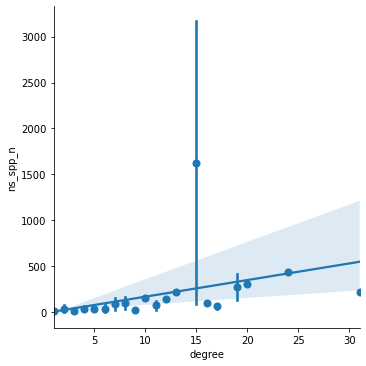

In [11]:
sns.lmplot(x='degree', y='ns_spp_n', data=degree_df, x_estimator=np.mean)
# https://seaborn.pydata.org/tutorial/regression.html

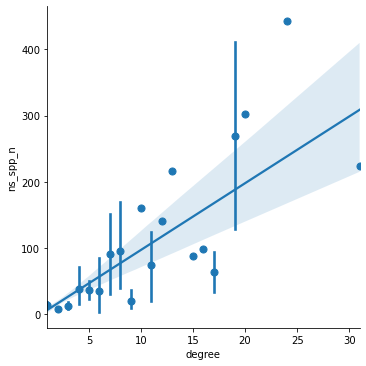

In [12]:
condition = degree_df['ns_spp_n'] <500
sns.lmplot(x='degree', y='ns_spp_n', data=degree_df[condition], x_estimator=np.mean)
# https://seaborn.pydata.org/tutorial/regression.html

In [13]:
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
eigenvector_df = pd.DataFrame.from_dict(eigenvector_dict, orient="index", columns=['value'])
eigenvector_df = eigenvector_df.reset_index()

print(eigenvector_df.sort_values('value', ascending=False)[0:10])
print("\nMedian eigenvector centrality:", s.median(eigenvector_df['value']))

                                 index     value
353                Michael Scott Engel  0.458887
313            Charles Duncan Michener  0.337522
377                  Terry L. Griswold  0.307806
381               Victor Hugo Gonzalez  0.292760
253              Ricardo Ayala Barajas  0.222091
332     Ismael Alejandro Hinojosa-Díaz  0.214119
366                   Robert W. Brooks  0.172822
341               John Stoskopf Ascher  0.161856
65   Gabriel Augusto Rodrigues de Melo  0.135301
355              Molly Greer Rightmyer  0.133774

Median eigenvector centrality: 0.0033607211661788616


**Eigenvector centrality** is an extension, including values from the neighbour's centrality too.

In [14]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient="index", columns=["value"])
betweenness_df = betweenness_df.reset_index()

print(betweenness_df.sort_values('value', ascending=False)[0:10])
print("\nMedian betweenness centrality:", s.median(betweenness_df['value']))

                        index     value
313   Charles Duncan Michener  0.160293
353       Michael Scott Engel  0.145246
67       Jesus Santiago Moure  0.122388
33                Alain Pauly  0.100077
377         Terry L. Griswold  0.097858
235       Shôichi F. Sakagami  0.081497
32         Maximilian Schwarz  0.069426
229            Osamu Tadauchi  0.065253
381      Victor Hugo Gonzalez  0.056359
360  Philip Hunter Timberlake  0.054420

Median betweenness centrality: 0.0


**Betweenness centrality** tabulates minimum of all shortest paths (see below) to pass through that node. Range from 0 to 1.
 

In [15]:
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

cen_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

check = (cen_df['degree'] <= 5) & (cen_df['betweenness'] >= s.median(cen_df['betweenness'])) # use 4 instead of median of 1
brokers = cen_df[['degree', 'betweenness', 'country_of_residence']][check].sort_values('betweenness', ascending=False)[1:20]
print(brokers)
brokers.to_csv(ddir_analysis +'ch3-coauth/2019-11-07-coauth-brokers.csv')

                                      degree  betweenness country_of_residence
Mariano Lucia                              3     0.021508                   AR
Silvana P. Durante                         3     0.021198                   AR
Maxim Yurievich Proshchalykin              5     0.017182                   RS
Jerome George Rozen, Jr.                   5     0.016411                   US
Andreas Müller                             4     0.014277                   SZ
Yuriy Andreyevich Pesenko                  5     0.012018                   RS
João Maria Franco de Camargo               5     0.011532                   BR
Jason Gibbs                                4     0.010981                   CA
Roy R. Snelling                            4     0.010900                   US
Keizô Yasumatsu                            3     0.010744                   JA
Zach M. Portman                            2     0.010718                   US
Holger Heinrich Dathe                      4     0.0

In [16]:
print(cen_df[cen_df.index=='Philip Hunter Timberlake'][['degree', 'eigenvector', 'country_of_residence']])
# Timberlake was a “bridge” to Michener and Cockerell. 

                          degree  eigenvector country_of_residence
Philip Hunter Timberlake       2     0.041883                   US


In [17]:
print(cen_df.sort_values("eigenvector", ascending=False)[["eigenvector", "degree"]][0:10])

                                   eigenvector  degree
Michael Scott Engel                   0.458887      31
Charles Duncan Michener               0.337522      24
Terry L. Griswold                     0.307806      19
Victor Hugo Gonzalez                  0.292760      16
Ricardo Ayala Barajas                 0.222091       9
Ismael Alejandro Hinojosa-Díaz        0.214119       9
Robert W. Brooks                      0.172822       8
John Stoskopf Ascher                  0.161856       6
Gabriel Augusto Rodrigues de Melo     0.135301      15
Molly Greer Rightmyer                 0.133774       5


In [18]:
print("Mean\n", round(cen_df.median(), 5))
print("Count\n", cen_df.count())

Mean
 ns_spp_n       3.00000
degree         1.00000
betweenness    0.00000
eigenvector    0.00336
dtype: float64
Count
 country_of_residence    391
ns_spp_n                391
degree                  391
betweenness             391
eigenvector             391
dtype: int64


A **broker** is one where clusters of subgraphs need to pass through you, they usually "have high betweenness centrality but low degree".


In [19]:
def shortest_path(n1, n2):
    shortest_path = nx.shortest_path(G, source=n1, target=n2)
    print("Shortest path between ", n1, " and ", n2, ":", shortest_path)
    print("Length of that path:", len(shortest_path)-1, "\n")
    
shortest_path("Theodore Dru Alison Cockerell", "Jesus Santiago Moure")
shortest_path("Chao-dong Zhu", "Michael Scott Engel")

Shortest path between  Theodore Dru Alison Cockerell  and  Jesus Santiago Moure : ['Theodore Dru Alison Cockerell', 'Philip Hunter Timberlake', 'Charles Duncan Michener', 'Jesus Santiago Moure']
Length of that path: 3 

Shortest path between  Chao-dong Zhu  and  Michael Scott Engel : ['Chao-dong Zhu', 'Michael Kuhlmann', 'Jason Gibbs', 'Laurence Packer', 'Michael Scott Engel']
Length of that path: 4 



**Shortest path** allows one to see how many "steps" it takes to reach from one node to another.

Possible analysis: how one important node from one "module" links to another important node in another "module", i.e. who are the bridges.

Network diameter of largest component: 11


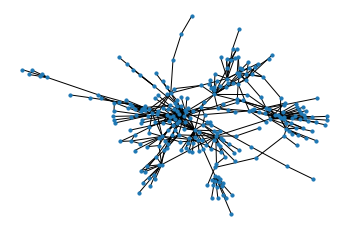

In [20]:
# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len) # max number of nodes

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

# Plot subgraph
plt.plot()
nx.draw(subgraph, with_labels=False, node_size=10)

# How to improve graphing: https://networkx.github.io/documentation/latest/auto_examples/index.html

**Network diameter** is the length of the longest of shortest path in the network. Gives idea of size of network from one end to another. The largest subgraph gives an idea of the diameter of the entire network.

Compared to Newman (2006), the diameter range from 20-30. Here, it's 11, suggesting it is more connected.

In [21]:
# Get subgraphs
subgraphs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print("Number of subgraphs:", len(subgraphs))
dia_li = []
nod_li = []
for i in subgraphs:
    dia_li.append(nx.diameter(G.subgraph(i)))
    nod_li.append(len(i))

print("Median diameter:", s.median(dia_li))
print("Diameter:", dia_li, "\n")

print("Median number of nodes:", s.median(nod_li))
print("Number of nodes when = 2 nodes:", sum([x==2 for x in nod_li]))
print("Number of nodes:", nod_li)

Number of subgraphs: 46
Median diameter: 1.0
Diameter: [11, 2, 2, 3, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 

Median number of nodes: 2.0
Number of nodes when = 2 nodes: 34
Number of nodes: [275, 6, 6, 5, 5, 5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [22]:
subgraph_info = {}
total_spp = 0

for i in range(1, nod_li.index(2)):
    
    subgraph = subgraphs[i]
    countries = Counter([G.nodes()[p]["country_of_residence"] for p in subgraph])
    N_species_li = [list(spp[spp["full_name_of_describer"] == p].idx) for p in subgraph]
    N_species = set(list(reduce(lambda x,y: x+y, N_species_li)))
    N_synonyms = len([x for x in N_species if x > 20669])
    N_species = len(N_species)
    print(len(subgraph), N_species, N_synonyms, subgraph,  dict(countries))
    
    subgraph_info[i] = {
        'N_species': N_species,
        'N_synonyms': N_synonyms,
        'N_nodes': len(subgraph),
        'id_nodes': subgraph,
        'countries': dict(countries)
    }
    
    total_spp = total_spp + N_species
    
coauth_df = pd.DataFrame.from_dict(subgraph_info, orient='index')

6 6 1 {'Thomas Lecocq', 'Michael Terzo', 'Nicolas Brasero', 'Paulo Biella', 'Pierre Rasmont', 'Baptiste Martinet'} {'BE': 5, 'IT': 1}
6 35 4 {'Sabita Simlote', 'Sundar Lal Sharma', 'Rajiv K. Gupta', 'P. Girish Kumar', 'V. K. Tewari', 'Gaurav Sharma'} {'IN': 6}
5 33 0 {'Katja Hogendoorn', 'Glynn Vivian Maynard', 'Terry Francis Houston', 'Michael Batley', 'Remko Leijs [or Leys]'} {'AS': 5}
5 2 0 {'Sydney Cameron', 'Paul Hugh Williams', 'Jian Yao', 'Sydney G. Cannings', 'Ya Tang'} {'US': 2, 'UK': 1, 'CA': 1, 'CH': 1}
5 3 3 {'Alejandro Parra-H', 'Rodulfo Ospina-Torres', 'Juan Carlos Sandino-Franco', 'Santiago Ramírez', 'Robert Louis Dressler'} {'CO': 3, 'US': 1, 'PM': 1}
4 10 0 {'Simon M. Tierney', 'Mark I. Stevens', 'Michael P. Schwarz', 'James B. Dorey'} {'AS': 3, 'AU': 1}
4 2 2 {'Randall Hepburn', 'Deborah Roan Smith', 'Sarah Radloff', 'Gard Otis'} {'US': 2, 'SF': 1, 'CA': 1}
4 3 3 {'Dieter Wittmann', 'Marlene Lucia Aguilar-Benavides', 'José Ricardo Cure', 'Cindy Julieth Celis'} {'GM': 

In [23]:
coauth_df['synonymy_rate'] = (coauth_df['N_synonyms'] / coauth_df['N_species'])
coauth_df.to_csv(ddir_analysis+'ch3-coauth/2019-11-07-coauth-subgraphs.csv')
print("Total species contribution:", total_spp)

scipy.stats.ttest_1samp(coauth_df['synonymy_rate'], .35)

Total species contribution: 119


Ttest_1sampResult(statistic=0.696158617377755, pvalue=0.5021886642986382)

In [24]:
np.mean(coauth_df['synonymy_rate'])

0.4497835497835498

In [25]:
scipy.stats.sem(coauth_df['synonymy_rate'])

0.14333450350641064

In [26]:
total_spp

119

                 0                  1              2
0    Thomas Lecocq       Paulo Biella  {'weight': 1}
1    Thomas Lecocq  Baptiste Martinet  {'weight': 1}
2    Thomas Lecocq     Pierre Rasmont  {'weight': 1}
3    Michael Terzo     Pierre Rasmont  {'weight': 4}
4  Nicolas Brasero  Baptiste Martinet  {'weight': 1}
5  Nicolas Brasero     Pierre Rasmont  {'weight': 1}
6     Paulo Biella  Baptiste Martinet  {'weight': 1}
7     Paulo Biella     Pierre Rasmont  {'weight': 1}
8   Pierre Rasmont  Baptiste Martinet  {'weight': 2}


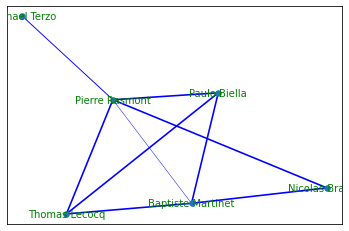

In [27]:
# Plotting one of the subgraphs
S = G.subgraph(subgraphs[1])
print(pd.DataFrame(S.edges(data=True)))
pos=nx.spring_layout(S) 
nx.draw_networkx_nodes(S, pos, node_size=30)
nx.draw_networkx_labels(S, pos, font_size=10,font_color='g')

all_weights = []
for (n1, n2, attr) in S.edges(data=True):
    all_weights.append(attr['weight'])
unique_weights = list(set(all_weights))

for wt in range(1, int(max(unique_weights))+1):
    edges = [(n1,n2) for (n1, n2, attr) in S.edges(data=True) if attr['weight']==wt]
    width = wt*len(edges)*3.0/sum(all_weights)
    nx.draw_networkx_edges(S, pos, edgelist=edges, width=width, edge_color='b')

This shows that there is one main "subgraph"/"network" with many other tiny subgraphs with authors that have residence in one dominant country and other countries in the network tend to be countries nearby.

Possible analysis: check how many "species" outputs the smaller subgraphs have to test their influence. For example, the "Jian Yao" network only described 3 species in total (not including those individually described/collaboratively) whereas the "Friese" network described 19 species.

Quote from tutorial: "This only scratches the surface of what can be done with network metrics in Python. NetworkX offers dozens of functions and measures for you to use in various combinations, and you can use Python to extend these measures in almost unlimited ways. A programming language like Python or R will give you the flexibility to explore your network computationally in ways other interfaces cannot by allowing you to combine and compare the statistical results of your network with other attributes of your data (like the dates and occupations you added to the network at the beginning of this tutorial!)."

## Modularity

In [28]:
communities = community.best_partition(G)

In [29]:
nx.set_node_attributes(G, communities, 'modularity')

In [30]:
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]; len(class0)

15

In [31]:
# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

In [32]:
# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: Maximilian Schwarz | Eigenvector Centrality: 0.08084146449549443
Name: Fritz Josef [Friedrich] Gusenleitner | Eigenvector Centrality: 0.01635333120213761
Name: Karl Mazzucco | Eigenvector Centrality: 0.012015231943082728
Name: Esther Ockermüller | Eigenvector Centrality: 0.011209840199713222
Name: Jan Smit | Eigenvector Centrality: 0.011209840199713222


In [33]:
modularity = {} # Create a new, empty dictionary
for k,v in communities.items(): # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k] # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k) # Append a name to the list for a modularity class the code has already seen

for k,v in modularity.items(): # Loop through the new dictionary
    if len(v) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(k)+':', v) # Print out the classes and their members

Class 0: ['Kamel Louadi', 'Noudjoud Benarfa', 'Esther Ockermüller', 'Fritz Josef [Friedrich] Gusenleitner', 'Gerald Hölzler', 'Karl Mazzucco', 'Maximilian Schwarz', 'Klaus Standfuss', 'Anselm Kratochwil', 'Erwin Scheuchl', 'Gideon Pisanty', 'Ardeshir Ariana', 'Jan Smit', 'Timofey Victorovich Levchenko', 'Canan Hazir']
Class 1: ['Alberto H. Abrahamovich', 'Arturo Roig-Alsina', 'Juan Pablo Torretta', 'Leopoldo J. Alvarez', 'Luis A. Compagnucci', 'Mariano Lucia', 'María Fernanda Rodríguez', 'Rocío Ana González-Vaquero', 'Silvana P. Durante', 'Boris O. Schlumpberger']
Class 2: ['Manfredo A. Fritz', 'Daniel H. Tapia', 'Elizabeth Chiappa', 'Fresia Rojas [Alvarez]', 'Haroldo Toro [Guttierez]', 'Luisa Ruz', 'Sharon Rodríguez', 'M. Herrera', 'Andrew R. Moldenke', 'Victor Cabezas']
Class 4: ['Glynn Vivian Maynard', 'Katja Hogendoorn', 'Michael Batley', 'Remko Leijs [or Leys]', 'Terry Francis Houston']
Class 5: ['James B. Dorey', 'Michael P. Schwarz', 'Simon M. Tierney', 'Mark I. Stevens']
Class 